In [1]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings(action='ignore')

data_path = '../input/data/train'

In [2]:
train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv')) # 전체 학습 데이터
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')

# user 영화 시청 sequence length vis

Text(0.5, 1.0, 'user sequence length')

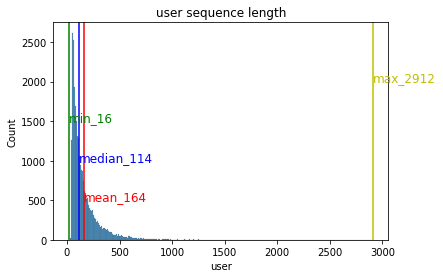

In [3]:
def get_show(title, val, col, x):
    plt.axvline(x = val, color=col)
    plt.text(val, x, f'{title}_{val}', color = col, fontsize=12)

sns.histplot(train_df["user"].value_counts())

mean_val = train_df["user"].value_counts().mean()
median_val = train_df["user"].value_counts().median()
min_val = train_df["user"].value_counts().min()
max_val = train_df["user"].value_counts().max()

get_show(title = 'mean', val = int(mean_val), col = 'r', x = 500)
get_show(title = 'median', val = int(median_val), col = 'b', x = 1000)
get_show(title = 'min', val = int(min_val), col = 'g', x = 1500)
get_show(title = 'max', val = int(max_val), col = 'y', x = 2000)

plt.title('user sequence length')

# 유저가 영화를 소비한 연도

In [4]:
train_df['year'] = train_df['time'].apply(lambda x : time.localtime(x).tm_year)

<AxesSubplot:xlabel='year', ylabel='count'>

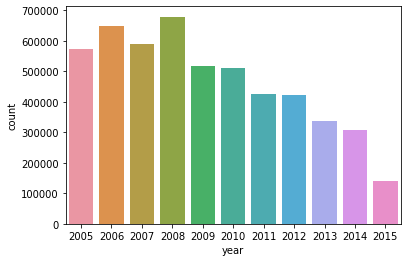

In [5]:
sns.countplot(train_df['year'])

# 영화 결측치 확인

In [6]:
# 2005 년에 본 영화의 경우 주로 몇넌도 개봉 영화인지 파악


def get_item_in_year(train_df, title_data, year):
    '''
    2005년 까지의 영화 시청 기록안에는 미래의 영화 시청 기록이 없음
    따라서 user가 주로 소비한 영화의 시청 연도는 영화를 필터링 하는 것에 중요한 요소로 작용할 수 있음
    ex) 2005년 주로 영화를 시청한 유저는 2005년 이후에 개봉한 영화를 추천해주는 것은 사실상 의미가 없음 (근데 이건 본 대회 Task에만 적용하는 문제임) 
    '''
    item_list = train_df[train_df['year'] <= year]['item'].unique().tolist()
    item_list = title_data.set_index('item').loc[item_list, :]['year'].unique()
    print(f'{year} 년')
    if f'{year + 1}' in item_list : print(f'{year + 1} 존재 O')
    else: print(f'{year + 1} 존재 X')
    
    if f'{year}' in item_list : print(f'{year} 존재 O')
    else: print(f'{year} 존재 X')
    print()

In [7]:
import re

# year data에 결측치가 존재하여 따로 title에서 year를 가져옴

def get_title_year(x):
    # 가로 안에 있는 4자리의 숫자만 매칭
    pattern = r"\(([\d]{4})\)"
    ret = re.search(pattern, x)
    if ret: return ret.group(1)
    else: 
        if x == 'Fawlty Towers (1975-1979)': return '1975'
        if x == 'Big Bang Theory, The (2007-)': return '2007'

title_data['year'] = title_data['title'].apply(get_title_year)

In [8]:
for year in [i for i in range(2005, 2016)]:
    get_item_in_year(train_df, title_data, year = year)

2005 년
2006 존재 X
2005 존재 O

2006 년
2007 존재 X
2006 존재 O

2007 년
2008 존재 X
2007 존재 O

2008 년
2009 존재 X
2008 존재 O

2009 년
2010 존재 X
2009 존재 O

2010 년
2011 존재 X
2010 존재 O

2011 년
2012 존재 O
2011 존재 O

2012 년
2013 존재 O
2012 존재 O

2013 년
2014 존재 X
2013 존재 O

2014 년
2015 존재 O
2014 존재 O

2015 년
2016 존재 X
2015 존재 O



1. 미래에 이 영화를 봤으니깐 과거에 이 영화를 봤을 것이다? 라는 느낌의 예측
2. 과거에 이 영화를 봤으니깐 미래에 이 영화를 볼 것이다? 라는 느낌의 예측

# 자카르도 유사도 계산 (Item2Vec의 기본 가정 확인)

In [11]:
user2item_list = {}
group_df = train_df.groupby('user')
for key, df in group_df:
    user2item_list[key] = df['item'].tolist()

In [17]:
from tqdm import tqdm

user_sim_list = {}
user_list = train_df['user'].unique().tolist()

for i in tqdm(user_list[:100]):
    user_sim = []
    for j in user_list:
        user_sim.append(
            (j, len(set(user2item_list[i]) & set(user2item_list[j])) / len(set(user2item_list[i]) | set(user2item_list[j])))
        )
    user_sim_list[i] = user_sim

100%|██████████| 100/100 [02:10<00:00,  1.30s/it]


In [21]:
user_sim_list.keys()

dict_keys([11, 14, 18, 25, 31, 35, 43, 50, 58, 60, 61, 65, 72, 77, 82, 85, 90, 91, 96, 98, 99, 102, 116, 121, 124, 129, 132, 133, 135, 136, 147, 152, 154, 155, 162, 163, 168, 175, 182, 189, 190, 201, 204, 205, 206, 208, 209, 211, 213, 215, 218, 220, 232, 237, 239, 241, 248, 252, 254, 258, 264, 266, 271, 279, 284, 285, 294, 304, 312, 313, 316, 317, 318, 337, 340, 342, 348, 351, 359, 361, 367, 370, 372, 375, 379, 383, 387, 388, 394, 395, 398, 407, 409, 413, 419, 421, 422, 425, 427, 430])

# Word2Vec 으로 영화 임베딩 시각화 하기

In [35]:
user_sentences = []
group_df = train_df.groupby('user')
for key, df in group_df:
    user_sentences.append(df['item'].tolist())

In [38]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.callbacks import CallbackAny2Vec
import datetime

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 1
        self.loss_to_be_subed = 0
        self.loss_now = 987654321

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        print(f'Loss after epoch {self.epoch}: {loss_now}, Total_loss : {loss}')

        self.loss_to_be_subed = loss
        if loss_now < self.loss_now:
            self.loss_now = loss_now
            model.save('Word2Vec_Embedding_Model.model')
            print('Model 저장')
        self.epoch += 1

start = datetime.datetime.now()

model = Word2Vec(
                sentences = user_sentences,
                seed = 0,
                epochs = 30,
                min_count = 1,
                vector_size = 100,
                sg = 1,
                negative = 2,
                window = 987654321,
                compute_loss = True, 
                callbacks=[callback()],
                 )

print("Time passed: " + str(datetime.datetime.now() - start))

Loss after epoch 1: 106029840.0, Total_loss : 106029840.0
Model 저장
Loss after epoch 2: 28187888.0, Total_loss : 134217728.0
Model 저장
Loss after epoch 3: 0.0, Total_loss : 134217728.0
Model 저장
Loss after epoch 4: 0.0, Total_loss : 134217728.0
Loss after epoch 5: 0.0, Total_loss : 134217728.0
Loss after epoch 6: 0.0, Total_loss : 134217728.0
Loss after epoch 7: 0.0, Total_loss : 134217728.0
Loss after epoch 8: 0.0, Total_loss : 134217728.0
Loss after epoch 9: 0.0, Total_loss : 134217728.0


KeyboardInterrupt: 

In [53]:
from gensim.models import Word2Vec

model = Word2Vec.load('Word2Vec_Embedding_Model.model')

item_li = train_df['item'].unique()

arr = []
for item in item_li:
    arr.append(model.wv[item])

arr = np.array(arr)

In [59]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state = 0)
new_arr = tsne.fit_transform(arr)

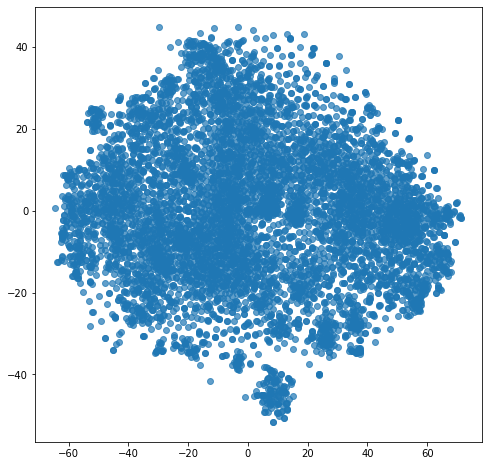

In [60]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))

ax.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.7)

plt.show()

# 유저 테이블 만들기